In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any, List

In [2]:
# Data classes:
class BatteryParams:
    def __init__(self, capacity_kwh, cmax_kw, dmax_kw,
                 eta_c=0.95, eta_d=0.95,
                 soc_min=0.1, soc_max=1.0,
                 soc_init=0.5, soc_target=None):
        self.capacity_kwh = capacity_kwh
        self.cmax_kw = cmax_kw
        self.dmax_kw = dmax_kw
        self.eta_c = eta_c
        self.eta_d = eta_d
        self.soc_min = soc_min
        self.soc_max = soc_max
        self.soc_init = soc_init
        self.soc_target = soc_target


class DayInputs:
    def __init__(self, prices_buy, demand_kw,
                 prices_sell=None, allow_export=False,
                 dt_hours=1.0):
        self.prices_buy = prices_buy
        self.demand_kw = demand_kw
        self.prices_sell = prices_sell
        self.allow_export = allow_export
        self.dt_hours = dt_hours


class SolveResponse:
    def __init__(self, status, objective_cost=None,
                 charge_kw=None, discharge_kw=None,
                 import_kw=None, export_kw=None, soc=None, message=None):
        self.status = status
        self.objective_cost = objective_cost
        self.charge_kw = charge_kw
        self.discharge_kw = discharge_kw
        self.import_kw = import_kw
        self.export_kw = export_kw
        self.soc = soc
        self.message = message

In [3]:
def solve_daily_milp(
    batt: BatteryParams,
    day: DayInputs,
    solver: Optional[str] = None,
    solver_opts: Optional[Dict[str, Any]] = None,
) -> SolveResponse:

    T = len(day.prices_buy)
    if len(day.demand_kw) != T:
        return SolveResponse(status="error", message="prices_buy and demand_kw lengths differ")

    dt   = float(day.dt_hours)
    C    = float(batt.capacity_kwh)
    eta_c, eta_d = float(batt.eta_c), float(batt.eta_d)
    soc_lo, soc_hi = float(batt.soc_min), float(batt.soc_max)
    soc0  = float(batt.soc_init)
    soc_tgt = soc0 if batt.soc_target is None else float(batt.soc_target)

    p_buy = np.asarray(day.prices_buy, dtype=float)
    load  = np.asarray(day.demand_kw, dtype=float)
    if day.allow_export:
        p_sell = np.asarray(day.prices_sell if day.prices_sell is not None else day.prices_buy, dtype=float)
    else:
        p_sell = None

    # Variables
    c   = cp.Variable(T, nonneg=True, name="charge_kw")
    d   = cp.Variable(T, nonneg=True, name="discharge_kw")
    imp = cp.Variable(T, nonneg=True, name="import_kw")
    exp = cp.Variable(T, nonneg=True, name="export_kw") if day.allow_export else None

    y_c = cp.Variable(T, boolean=True, name="y_charge")
    y_d = cp.Variable(T, boolean=True, name="y_discharge")

    soc = cp.Variable(T+1, name="soc")

    cons = [
        soc >= soc_lo, soc <= soc_hi,
        soc[0] == soc0, soc[T] >= soc_tgt
    ]
    for t in range(T):
        cons += [
            c[t] <= batt.cmax_kw * y_c[t],
            d[t] <= batt.dmax_kw * y_d[t],
            y_c[t] + y_d[t] <= 1,
            soc[t+1] == soc[t] + (eta_c*c[t]*dt - (d[t]*dt)/eta_d)/C,
        ]
        net = load[t] + c[t] - d[t]
        if day.allow_export:
            cons += [imp[t] - exp[t] == net]
        else:
            cons += [imp[t] >= net]

    if day.allow_export:
        objective = cp.sum(p_buy * imp * dt) - cp.sum(p_sell * exp * dt)
    else:
        objective = cp.sum(p_buy * imp * dt)

    prob = cp.Problem(cp.Minimize(objective), cons)

    if solver is None:
        for cand in ["GUROBI", "CPLEX", "CBC", "GLPK_MI", "ECOS_BB"]:
            if cand in cp.installed_solvers():
                solver = cand
                break

    if solver_opts is None:
        solver_opts = {}

    try:
        if solver:
            prob.solve(solver=solver, **solver_opts)
        else:
            prob.solve(**solver_opts)
    except Exception as e:
        return SolveResponse(status="error", message=str(e))

    return SolveResponse(
        status=prob.status,
        objective_cost=float(prob.value) if prob.value is not None else None,
        charge_kw=c.value.tolist() if c.value is not None else None,
        discharge_kw=d.value.tolist() if d.value is not None else None,
        import_kw=imp.value.tolist() if imp.value is not None else None,
        export_kw=(exp.value.tolist() if (day.allow_export and exp is not None and exp.value is not None) else None),
        soc=soc.value.tolist() if soc.value is not None else None
    )

In [4]:
T = 24
hours = np.arange(T)

prices = 50 + 20*np.sin(2*np.pi*hours/24)   # $/MWh, synthetic
demand = 5 + 2*np.cos(2*np.pi*hours/24)     # kW

batt = BatteryParams(
    capacity_kwh=20,
    cmax_kw=5,
    dmax_kw=5,
    soc_init=0.5,
)

day = DayInputs(prices_buy=prices, demand_kw=demand, dt_hours=1.0)

res = solve_daily_milp(batt, day)

print("Status:", res.status)
print("Objective cost:", res.objective_cost)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter WLSSecret
Set parameter LicenseID to value 2718037
Set parameter LicenseID to value 2718037


/Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


Academic license 2718037 - for non-commercial use only - registered to mi___@columbia.edu
Status: optimal
Objective cost: 5555.631598630741
Status: optimal
Objective cost: 5555.631598630741


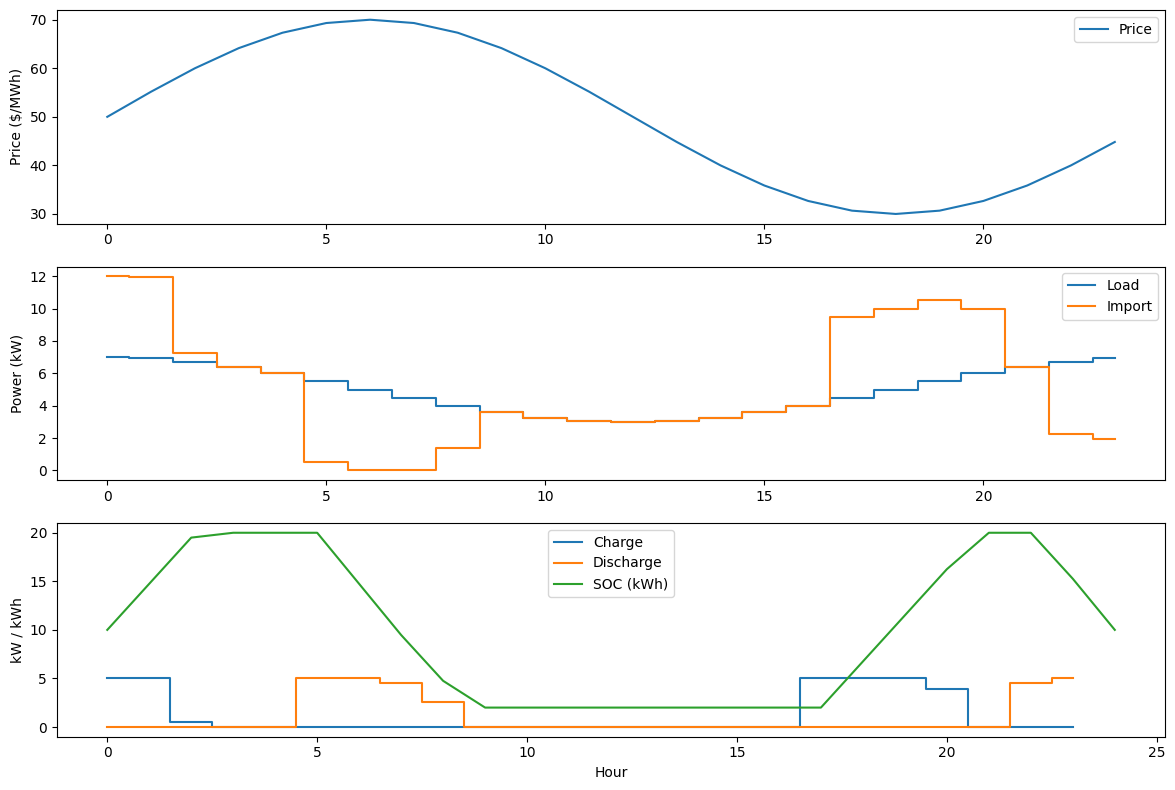

In [5]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(hours, prices, label="Price")
plt.ylabel("Price ($/MWh)")
plt.legend()

plt.subplot(3,1,2)
plt.step(hours, demand, label="Load", where='mid')
plt.step(hours, res.import_kw, label="Import", where='mid')
if res.export_kw:
    plt.step(hours, res.export_kw, label="Export", where='mid')
plt.ylabel("Power (kW)")
plt.legend()

plt.subplot(3,1,3)
plt.step(hours, res.charge_kw, label="Charge", where='mid')
plt.step(hours, res.discharge_kw, label="Discharge", where='mid')
plt.plot(range(T+1), np.array(res.soc)*batt.capacity_kwh, label="SOC (kWh)")
plt.xlabel("Hour")
plt.ylabel("kW / kWh")
plt.legend()

plt.tight_layout()
plt.show()
